In [2]:
cd ..

/home/ec2-user/uclresearchanalysis


In [3]:
import builtins
# builtins.uclresearch_topic = 'GIVENCHY'
builtins.uclresearch_topic = 'HAWKING'
# builtins.uclresearch_topic = 'NYC'
# builtins.uclresearch_topic = 'FLORIDA'
from configuration import config

('Reading config file from location: '
 '/home/ec2-user/uclresearchanalysis/configuration/env.properties')
{'calculate': {'analysis': True,
               'friends': True,
               'network': True,
               'uniquetweets': True,
               'uniqueusers': True},
 'data': {'dates': ['2018-03-13', '2018-03-14', '2018-03-15'],
          'eventname': "hawking's death",
          'phrases': ['stephen%20hawking%20death',
                      'stephen%20hawking%20die',
                      'stephen%20hawking%20passed%20away'],
          'starttime': 'Mar 13 12:00:00 -0500 2018'},
 'path': {'cwd': '/home/ec2-user/uclresearchanalysis/data/hawking',
          'ml': '/home/ec2-user/uclresearchanalysis/data/hawking/pickle',
          'networkx': {'all': '/home/ec2-user/uclresearchanalysis/data/hawking/pickle/networkx_all.dat',
                       'friends': '/home/ec2-user/uclresearchanalysis/data/hawking/pickle/networkx_friends.dat',
                       'potential': '/home/

In [4]:
%matplotlib inline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn import svm
from pandas import *
import pandas as pd
from pprint import pprint
import sys
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Parameters
interval = 30

# 1. Prepare
def prepare_data(interval):
    df = config.load_ml_data(interval)
    df = df.reset_index(drop=True)
    
    # Converting all type to float, to prepare for feature selection
    df = df.astype('float')
    # Reset index, with drop equals to true to avoid setting old index as a new column
    df = df.reset_index(drop=True)
    # Visualize distribution
    print('[Original] data counts, with uninfected (0): {}, infected (1): {}'.format(
        df['label'].value_counts()[0],
        df['label'].value_counts()[1]
    ))
    df.groupby(['TwM_tCurrent','label']).size().unstack(fill_value=0).plot.bar(title='Original Data Distribution')
    
    columns = list(df.columns)
    columns.remove('label')
    
    X = df[columns]
    y = df[['label']]
    return df, X, y


Loading data file from path /home/ec2-user/uclresearchanalysis/data/hawking/pickle/30_data.dat
'Loaded 4828104 entires'
[Original] data counts, with uninfected (0): 1821013, infected (1): 3007091


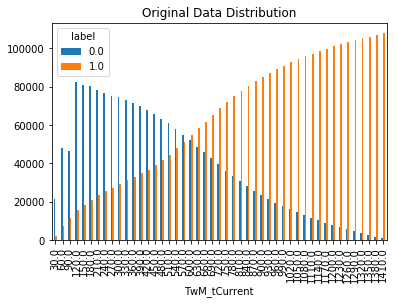

In [6]:
# 1. Prepare
df, X, y = prepare_data(interval)

In [7]:
len(X.columns)

67

In [8]:
def train(df, X, y, model, n_folds, model_name='Unknown'):
    # 2. N Fold Split
    # Stratified K-Folds cross-validator
    # Provides train/test indices to split data in train/test sets. 
    # This cross-validation object is a variation of KFold that returns stratified folds. 
    # The folds are made by preserving the percentage of samples for each class.
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
    
    corrDataframe = pd.DataFrame()    
    mse = []
    acc = []
    roc = []
    F1 = []
    auc = []
    acc_t = []
    fold_count = 0
    t_current = 210
#     number_of_features = len(X.columns)
    number_of_features = 60

    print("Start cross validation")
    for train, test in skf.split(X, y):
        print("===Processing fold %s===" % fold_count)
        train_fold = df.loc[train]
        test_fold = df.loc[test]

        # 3. Rebalance (Up-sampling)
        diff = sum(train_fold.label == 1) - sum(train_fold.label == 0)
        append_indices = np.random.choice(train_fold[train_fold.label == 0].index, diff, replace=True)
        new_sample = train_fold.loc[append_indices,:]
        train_fold = pd.concat([train_fold, new_sample])
        train_fold = train_fold.reset_index(drop=True)
        print('[Up-sampling] data counts, with uninfected (0): {}, infected (1): {}'.format(
            train_fold['label'].value_counts()[0],
            train_fold['label'].value_counts()[1],
        ))
        
        # 4. Feature Selection
        corr = train_fold.corr()['label'][train_fold.corr()['label'] < 1].abs()
        corr = corr.sort_values(ascending=False)
        corrDataframe = corrDataframe.append(pd.DataFrame(corr.rename('cv{}'.format(fold_count))).T)

        features = corr.index[range(number_of_features)].values
#         train_fold_input  = SelectKBest(chi2, k=50).fit_transform(train_fold[X.columns], train_fold['label'])
        print("Features selected: {}".format(features))
        train_fold_input = train_fold[features]
        train_fold_output = train_fold['label']
        
        # 5. Training
        model.fit(train_fold_input, train_fold_output)
        config.dump_ml_model(model, '{}_{}'.format(model_name, fold_count))

        # 6. Testing
        # Check MSE on test set
        test_fold_t = test_fold[test_fold.TwM_tCurrent == t_current]
        pred = model.predict(test_fold[features])
        pred_t = model.predict(test_fold_t[features])
        mse.append(mean_squared_error(test_fold.label, pred))
        acc.append(accuracy_score(test_fold.label, pred))
        roc.append(roc_auc_score(test_fold.label, pred))
        F1.append(f1_score(test_fold.label,pred))
        acc_t.append(accuracy_score(test_fold_t.label, pred_t))
        cm = confusion_matrix(test_fold.label, pred)
        print(cm)

        # Done with the fold
        fold_count += 1
    print("Finished cross validation")
    print("MSE: {} ".format(DataFrame(mse).mean()))
    print("ACC: {} ".format(DataFrame(acc).mean()))
    print("AUC: {} ".format(DataFrame(roc).mean()))
    print("F1: {} ".format(DataFrame(F1).mean()))
    print("ACC for t at {}: {} ".format(t_current, DataFrame(acc_t).mean()))
    corrDataframe = corrDataframe.T
    corrDataframe['average corr'] = corrDataframe.mean(numeric_only=True, axis=1)
    print(corrDataframe.sort_values(by=['average corr'], ascending=False).to_string())
    return model

In [ ]:
# Naive Bayes
train(df, X, y, GaussianNB(), 10， 'GaussianNB')

In [ ]:
# Logistic Regression
train(df, X, y, LogisticRegression(), 10, 'LogisticRegression')


In [9]:
# Random Forest 10 folds
rf_10 = train(df, X, y, RandomForestClassifier(n_estimators= 100,min_samples_split=2,
                                  min_samples_leaf=1,random_state=10), 10, 'RandomForest')

Start cross validation
===Processing fold 0===
[Up-sampling] data counts, with uninfected (0): 163003, infected (1): 163003
Features selected: ['TwM_t0' 'TwM_tCurrent' 'Stat_average_t' 'TwM_t-1'
 'Nw_outDegreeCentrality-1' 'Nw_degreeCentrality-1' 'Stat_min_kOut'
 'Stat_average_kOut' 'Nw_inDegreeCentrality-1'
 'UsM_normalizedUserFriendsCount-1' 'UsM_friendsCount-1'
 'Stat_average_friendsCount' 'Stat_average_normalizedUserFriendsCount'
 'Nw_eigenvectorCentrality-1' 'Nw_nNodes' 'Stat_average_deltaDays'
 'UsM_deltaDays-1' 'Nw_averageNeighborDegree'
 'UsM_normalizedUserListedCount-1' 'Nw_averageNeighborDegree-1'
 'UsM_listedCount-1' 'UsM_favouritesCount0'
 'UsM_normalizedUserFavouritesCount0' 'UsM_followersCount0'
 'UsM_normalizedUserFollowersCount0' 'UsM_listedCount0'
 'UsM_normalizedUserFriendsCount0' 'UsM_normalizedUserListedCount0'
 'UsM_friendsCount0' 'Nw_outDegreeCentrality0' 'Nw_degreeCentrality0'
 'Nw_inDegreeCentrality0' 'Nw_eigenvectorCentrality0' 'UsM_deltaDays'
 'UsM_normalizedU

/home/ec2-user/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Features selected: ['TwM_t0' 'TwM_tCurrent' 'Stat_average_t' 'TwM_t-1'
 'Nw_outDegreeCentrality-1' 'Nw_degreeCentrality-1' 'Stat_min_kOut'
 'Stat_average_kOut' 'Nw_inDegreeCentrality-1'
 'UsM_normalizedUserFriendsCount-1' 'UsM_friendsCount-1'
 'Stat_average_friendsCount' 'Stat_average_normalizedUserFriendsCount'
 'Nw_eigenvectorCentrality-1' 'Nw_nNodes' 'Stat_average_deltaDays'
 'UsM_deltaDays-1' 'Nw_averageNeighborDegree'
 'UsM_normalizedUserListedCount-1' 'Nw_averageNeighborDegree-1'
 'UsM_listedCount-1' 'UsM_favouritesCount0'
 'UsM_normalizedUserFavouritesCount0' 'UsM_normalizedUserFriendsCount0'
 'UsM_normalizedUserFollowersCount-1' 'UsM_friendsCount0'
 'Nw_outDegreeCentrality0' 'Nw_degreeCentrality0' 'UsM_followersCount0'
 'UsM_deltaDays' 'UsM_normalizedUserFollowersCount0'
 'Nw_inDegreeCentrality0' 'Nw_eigenvectorCentrality0' 'UsM_listedCount0'
 'UsM_normalizedUserListedCount0' 'Stat_average_normalizedUserListedCount'
 'UsM_followersCount-1' 'UsM_normalizedUserStatusesCount0'
 'U

KeyboardInterrupt: 

In [10]:
rf_2 = train(df, X, y, RandomForestClassifier(n_estimators= 100,min_samples_split=2,
                                  min_samples_leaf=1,random_state=10), 2)

Start cross validation
===Processing fold 0===
[Up-sampling] data counts, with uninfected (0): 90557, infected (1): 90557
Features selected: ['TwM_t0' 'TwM_tCurrent' 'Stat_average_t' 'TwM_t-1'
 'Nw_outDegreeCentrality-1' 'Nw_degreeCentrality-1' 'Stat_min_kOut'
 'Stat_average_kOut' 'Nw_inDegreeCentrality-1'
 'UsM_normalizedUserFriendsCount-1' 'UsM_friendsCount-1'
 'Stat_average_friendsCount' 'Stat_average_normalizedUserFriendsCount'
 'Nw_eigenvectorCentrality-1' 'Nw_nNodes' 'Stat_average_deltaDays'
 'UsM_deltaDays-1' 'Nw_averageNeighborDegree'
 'UsM_normalizedUserListedCount-1' 'Nw_averageNeighborDegree-1'
 'UsM_favouritesCount0' 'UsM_normalizedUserFavouritesCount0'
 'UsM_listedCount-1' 'UsM_deltaDays' 'UsM_normalizedUserFollowersCount0'
 'UsM_followersCount0' 'UsM_normalizedUserStatusesCount0'
 'UsM_listedCount0' 'UsM_normalizedUserFriendsCount0'
 'UsM_normalizedUserListedCount0' 'UsM_friendsCount0'
 'Nw_outDegreeCentrality0' 'Nw_degreeCentrality0' 'Nw_inDegreeCentrality0'
 'Nw_eigenve

/home/ec2-user/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Features selected: ['TwM_t0' 'TwM_tCurrent' 'Stat_average_t' 'TwM_t-1'
 'Nw_outDegreeCentrality-1' 'Nw_degreeCentrality-1' 'Stat_min_kOut'
 'Stat_average_kOut' 'Nw_inDegreeCentrality-1' 'UsM_friendsCount-1'
 'UsM_normalizedUserFriendsCount-1' 'Stat_average_friendsCount'
 'Stat_average_normalizedUserFriendsCount' 'Nw_eigenvectorCentrality-1'
 'Nw_nNodes' 'Stat_average_deltaDays' 'UsM_deltaDays-1'
 'Nw_averageNeighborDegree' 'UsM_normalizedUserListedCount-1'
 'Nw_averageNeighborDegree-1' 'UsM_listedCount-1' 'UsM_favouritesCount0'
 'UsM_normalizedUserFavouritesCount0' 'UsM_normalizedUserFollowersCount-1'
 'UsM_followersCount0' 'UsM_normalizedUserFollowersCount0'
 'UsM_normalizedUserFriendsCount0' 'UsM_listedCount0' 'UsM_deltaDays'
 'UsM_friendsCount0' 'UsM_normalizedUserListedCount0'
 'Nw_degreeCentrality0' 'Nw_outDegreeCentrality0' 'Nw_inDegreeCentrality0'
 'UsM_friendsCount' 'Nw_eigenvectorCentrality0' 'UsM_followersCount-1'
 'Stat_average_normalizedUserListedCount' 'Nw_outDegreeCentral

In [ ]:
importances=rf_10.feature_importances_

In [ ]:
rf_2.feature_importances_

In [ ]:
plt.figure()
plt.title("Feature importances")
plt.scatter(range(0,60), importances,  color="r")
# plt.xticks(range(X.shape[1]), indices)
# plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
# GBDT
train(df, X, y, GradientBoostingClassifier(n_estimators=150, min_samples_split=30,
                                  min_samples_leaf=2,max_depth=12,max_features='sqrt', subsample=0.8,random_state=10), 10)